In [1]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import cufflinks as cf
from sklearn.metrics import mean_absolute_percentage_error
cf.go_offline()

## Data Collection and Data Manipulation

In [2]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-10-22', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [3]:
nvda = get_finance_data('nvda')

In [4]:
nvda

,Open,High,Low,Close,Volume
Date,,,,,
2009-02-02,1.798400,1.945396,1.789213,1.924725,57799200
2009-02-03,1.929317,1.963770,1.876491,1.947692,39694800
2009-02-04,1.952286,2.101578,1.952286,2.002816,77923200
2009-02-05,1.949989,2.172779,1.929318,2.149811,91919200
2009-02-06,2.156702,2.280729,2.119953,2.266948,115788000
...,...,...,...,...,...
2021-10-15,218.100006,219.309998,216.619995,218.619995,22679500
2021-10-18,217.490005,222.910004,216.440002,222.220001,18949400
2021-10-19,222.759995,223.789993,220.369995,222.899994,16147300


In [5]:
nvda_close = nvda[['Close']]

## Data Visualization

In [6]:
nvda_close.iplot(title='Stock Close Prices', fill = True, xTitle='Dates',yTitle='Close Prices', theme='space')

In [7]:
nvda['Volume'].iplot(title='Volume', xTitle='Dates', yTitle='Volume', theme='space')

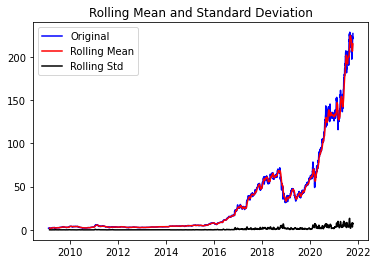

Results of dickey fuller test
Test Statistics                   5.571346
p-value                           1.000000
No. of lags used                 29.000000
Number of observations used    3174.000000
critical value (1%)              -3.432412
critical value (5%)              -2.862451
critical value (10%)             -2.567255
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(nvda_close)

<Figure size 432x288 with 0 Axes>

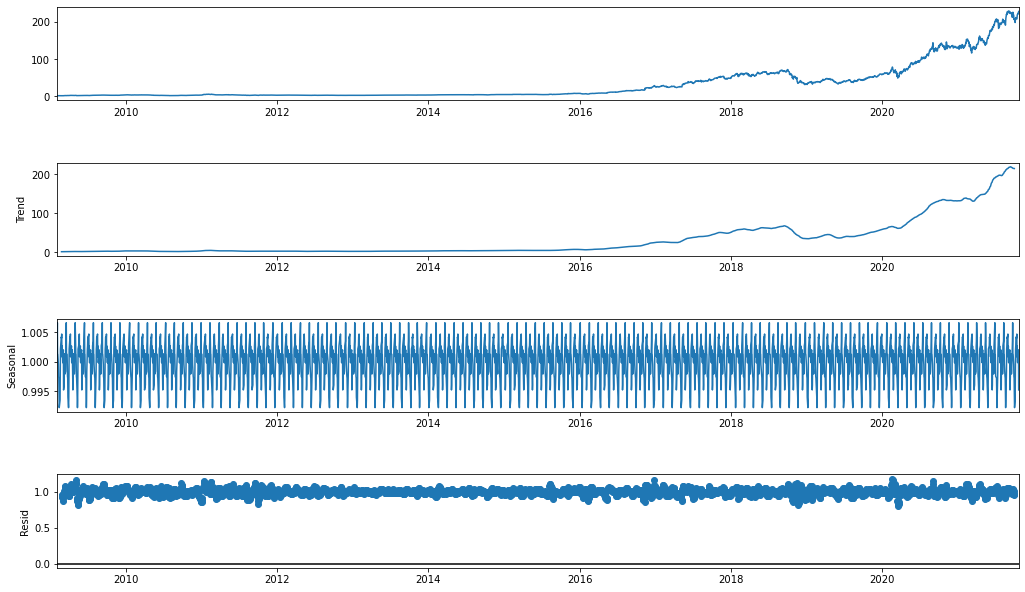

In [9]:
result = seasonal_decompose(nvda_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## Time Series Data Manipulation

In [10]:
nvda_close

,Close
Date,
2009-02-02,1.924725
2009-02-03,1.947692
2009-02-04,2.002816
2009-02-05,2.149811
2009-02-06,2.266948
...,...
2021-10-15,218.619995
2021-10-18,222.220001
2021-10-19,222.899994


## ADF Test

Check for stationary series using the Augmented Dickey Fuller Test.
The ADF test indicates whether or not differencing has to be done or not

In [11]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(nvda_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 5.571346
p-value: 1.000000


## Differencing Term (d)

Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

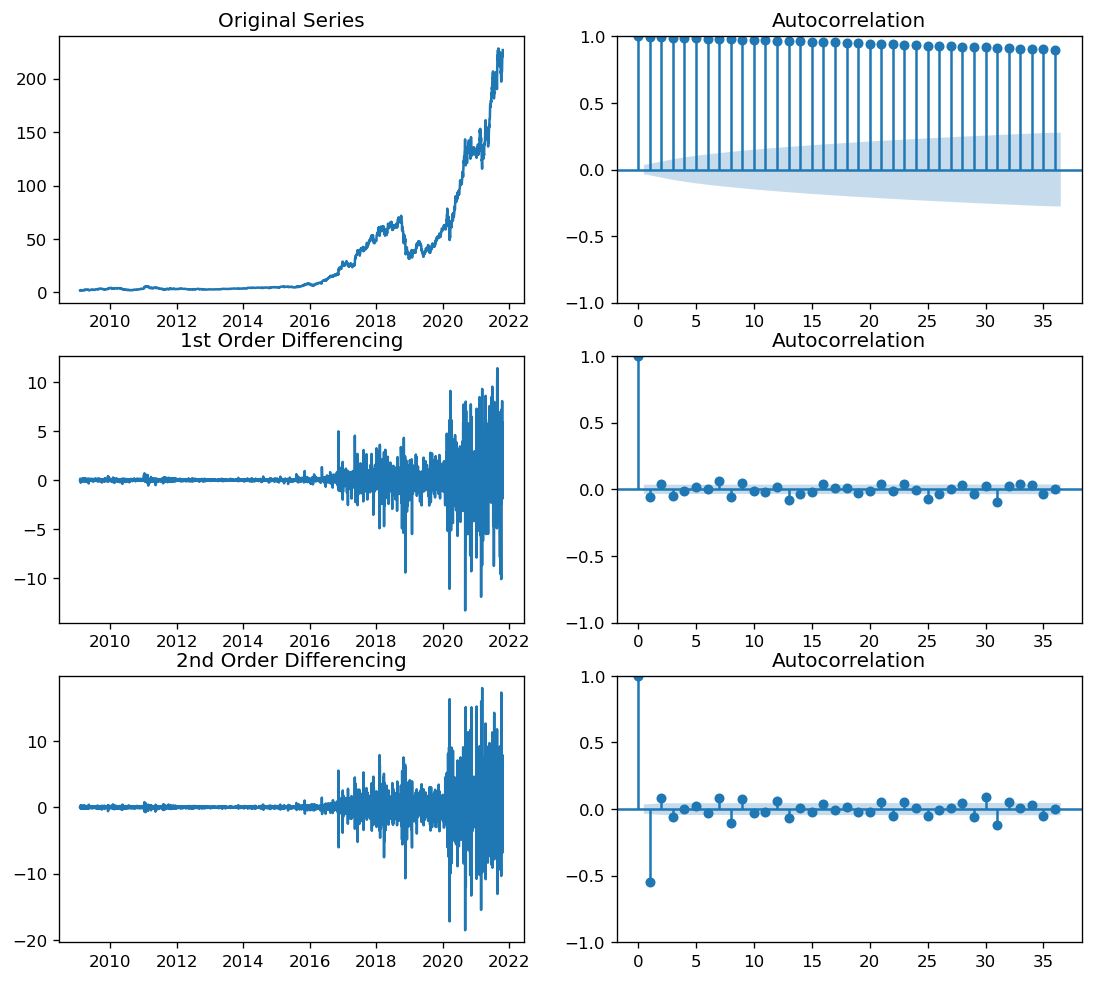

In [12]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(11,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(nvda_close); axes[0, 0].set_title('Original Series')
plot_acf(nvda_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(nvda_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(nvda_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(nvda_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(nvda_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced

## AR term (p)

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



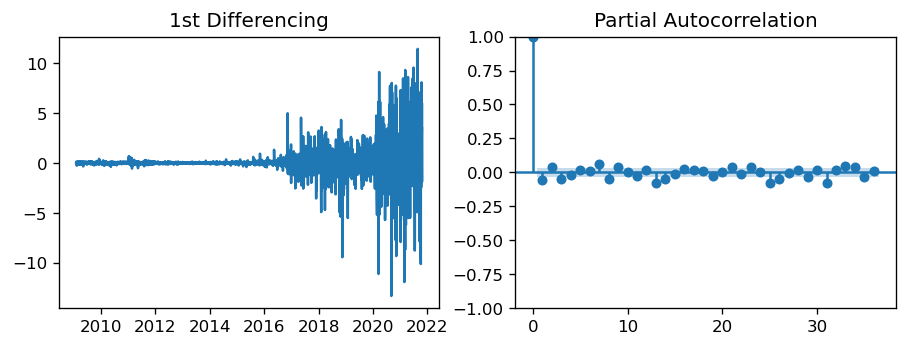

In [13]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(nvda_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(nvda_close.diff().dropna(), ax=axes[1])

plt.show()

ACF lag 1 is quite significant since is well above the significance line, that is why the lag term will be closer to 1

## MA Term (q)

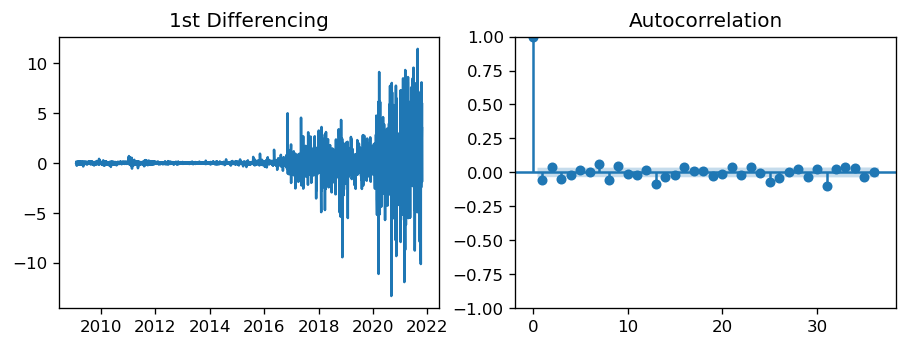

In [14]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2)
axes[0].plot(nvda_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(nvda_close.diff().dropna(), ax=axes[1])

plt.show()

The 1st lag is well above the signifigance line so the q term will be set to 1

# ARIMA Model

## Train-Test Split

In [15]:
n = int(len(nvda_close) * 0.80)
train = nvda_close[:n]
test = nvda_close[n:]

In [16]:
train

,Close
Date,
2009-02-02,1.924725
2009-02-03,1.947692
2009-02-04,2.002816
2009-02-05,2.149811
2009-02-06,2.266948
...,...
2019-04-02,45.509659
2019-04-03,46.907295
2019-04-04,46.817757


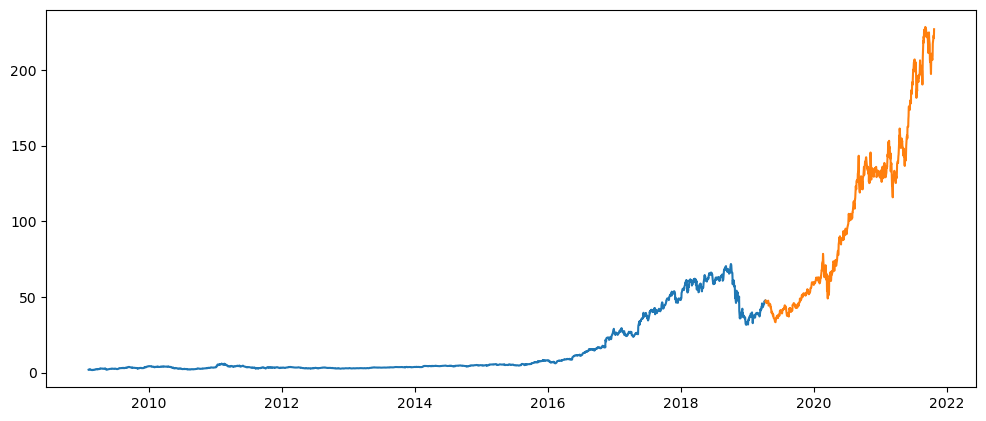

In [17]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')

## Prediction

In [18]:
model = SARIMAX(nvda_close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3204
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5824.551
Date:                Thu, 28 Oct 2021   AIC                          11655.102
Time:                        07:29:36   BIC                          11673.317
Sample:                             0   HQIC                         11661.632
                               - 3204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5225      0.076     -6.919      0.000      -0.671      -0.375
ma.L1          0.4632      0.077      5.988      0.000       0.312       0.615
sigma2         2.2234      0.018    122.860      0.0

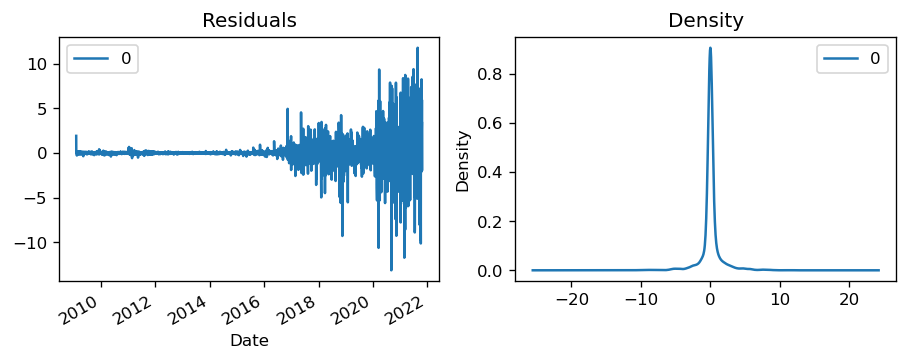

In [19]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [20]:
pred = model_fit.predict(start=pd.to_datetime('2019-04-08'), dynamic=False)
plt.show()

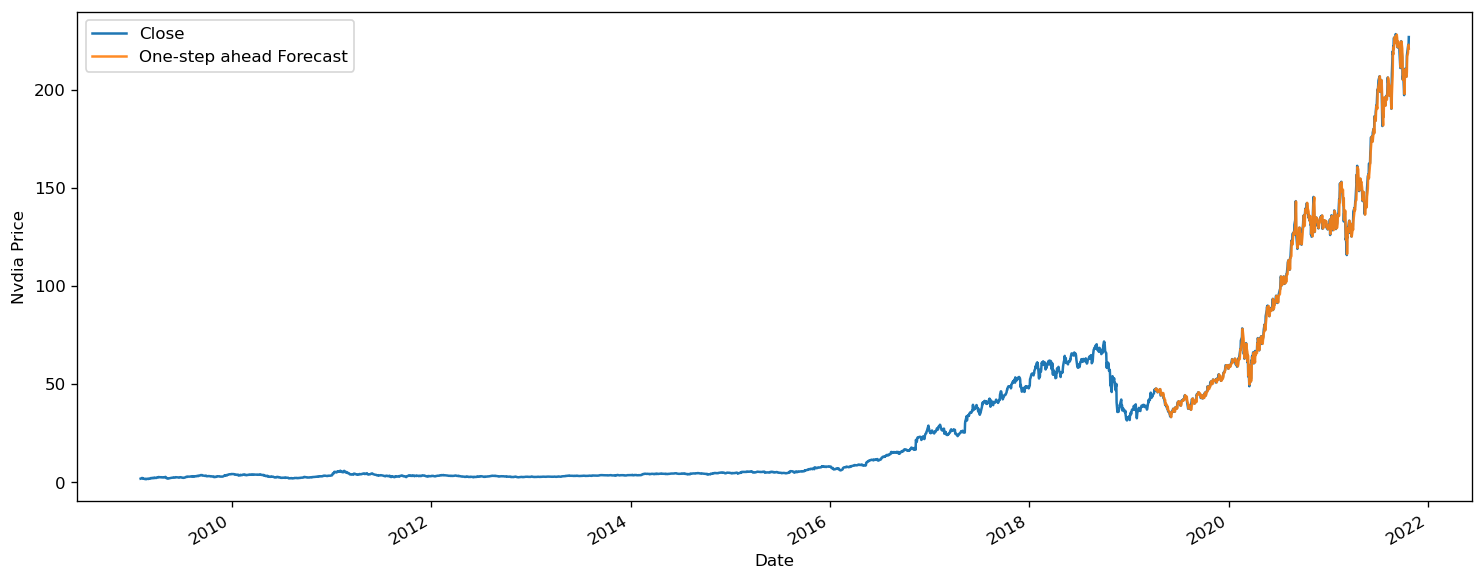

In [21]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nvda_close.plot(label='observed')

# Plot predicted values
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Nvdia Price')
plt.legend()

plt.show();

In [22]:
value_forecasted = pred
value_truth = nvda_close['Close']['2019-04-08':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 3.07


In [23]:
mean_absolute_percentage_error(value_truth, value_forecasted)

0.021025416048813472

# PMDARIMA 

In [24]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape

In [25]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [26]:
auto = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4970.073, Time=9.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5003.887, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5002.196, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5002.309, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5003.870, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5002.201, Time=2.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5003.277, Time=3.91 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4971.956, Time=6.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4971.972, Time=8.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5004.093, Time=1.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4996.756, Time=2.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4997.795, Time=2.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4973.388, Time=7.28 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=5.35 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] i

In [27]:
print(auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2563
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2479.036
Date:                Thu, 28 Oct 2021   AIC                           4970.073
Time:                        07:30:30   BIC                           5005.164
Sample:                             0   HQIC                          4982.797
                               - 2563                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0447      0.033      1.368      0.171      -0.019       0.109
ar.L1         -0.5848      0.013    -43.622      0.000      -0.611      -0.559
ar.L2         -0.9196      0.013    -71.296      0.0

In [28]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 9.633248882030816
SMAPE: 2.1374361000615454


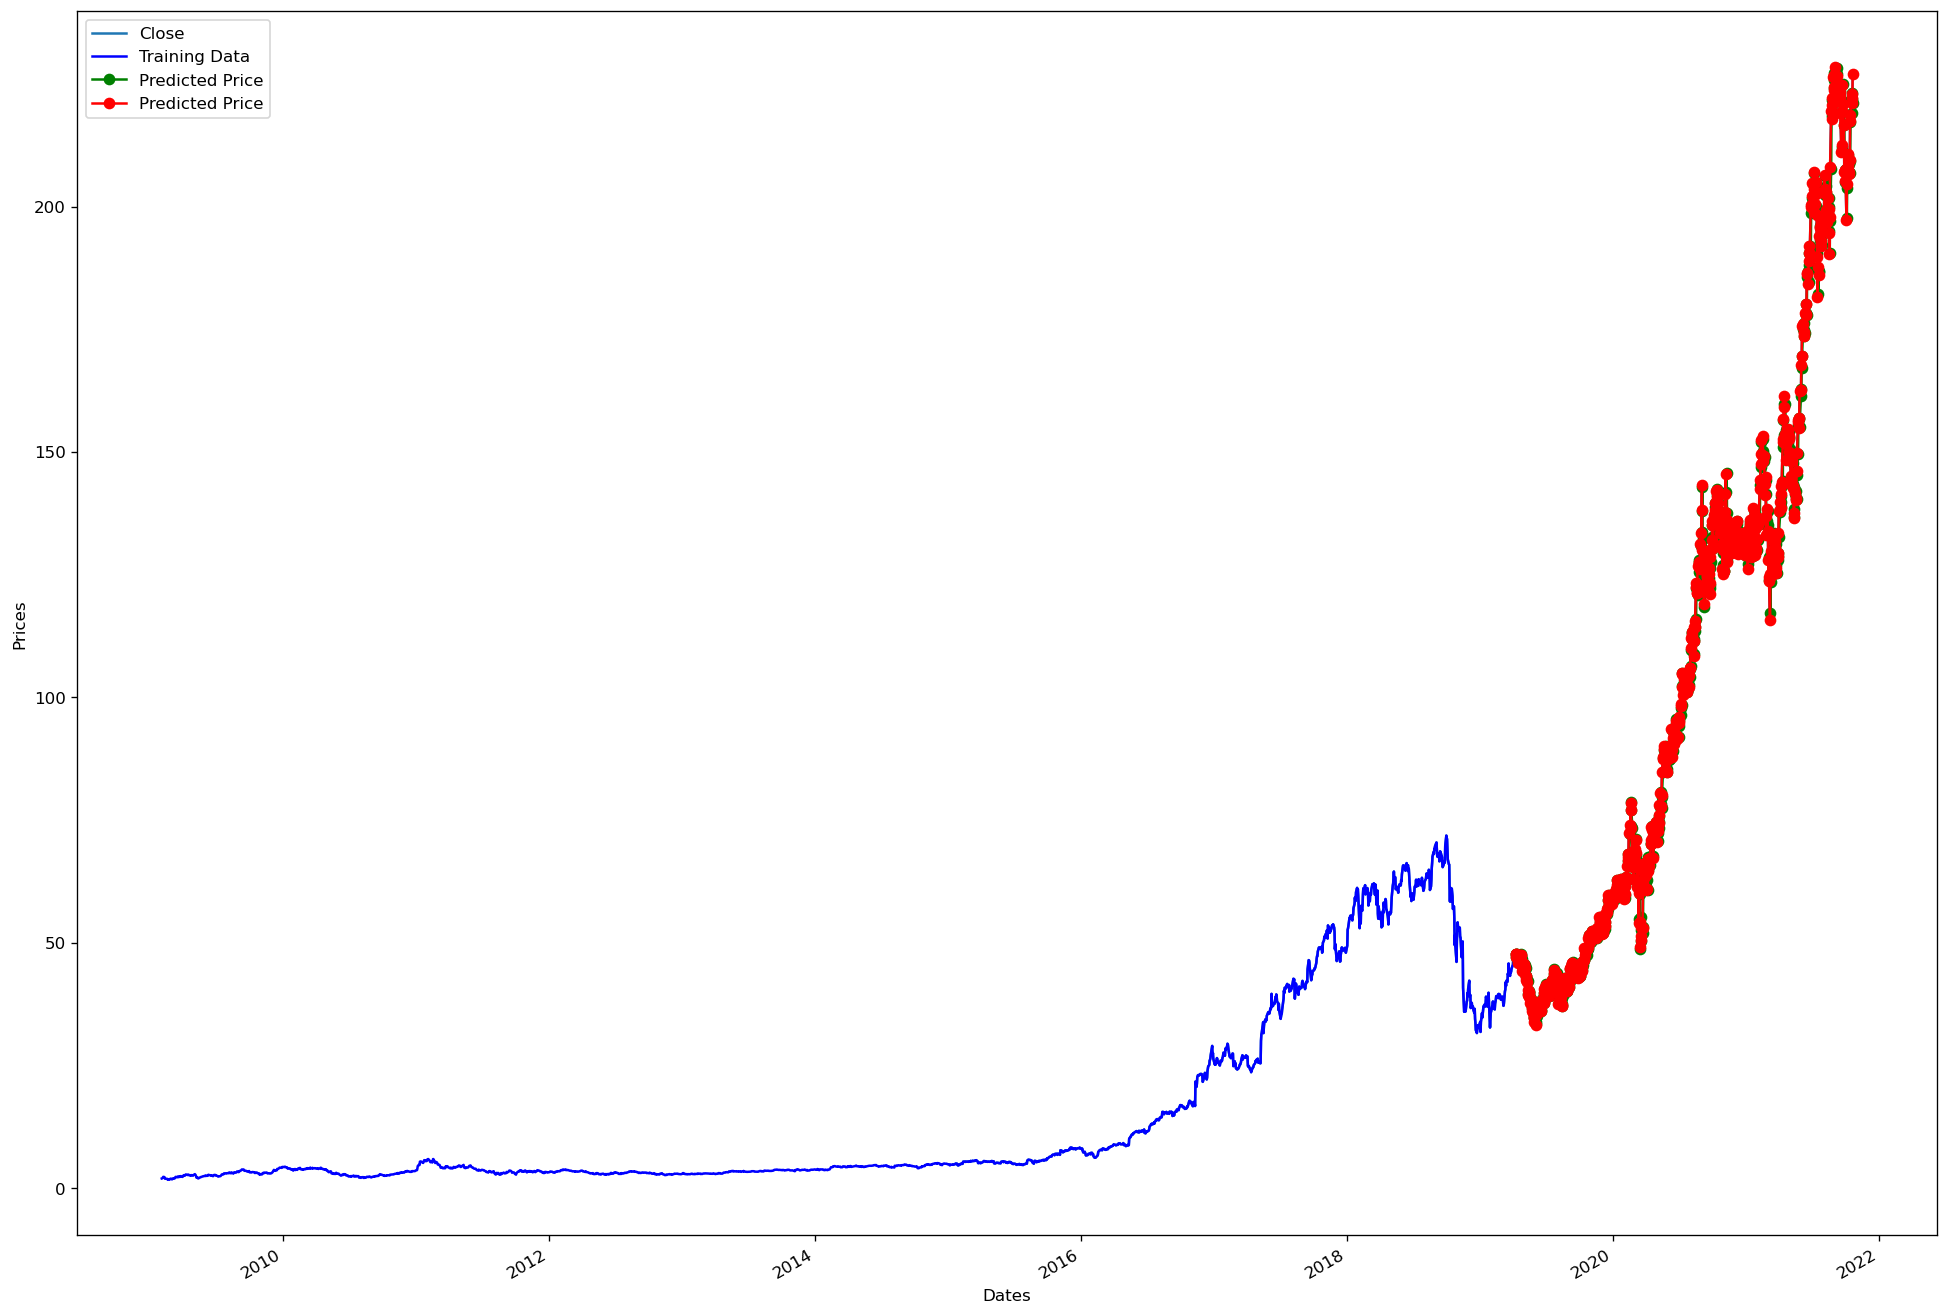

In [29]:
ax = nvda_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [30]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(9.715419101564516), 2)))

The Root Mean Squared Error of prediction is 3.12


## SARIMAX PMDARIMA

In [31]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=8.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11120.134, Time=0.22 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=5905.148, Time=3.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=8917.811, Time=3.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11141.194, Time=0.21 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=6542.205, Time=0.82 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=5719.361, Time=12.78 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=42.34 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=16.40 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=10993.808, Time=8.53 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=5721.125, Time=19.42 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=5721.131, Time=24.27 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=8851.999, Time=16.56 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=5723.358, Time=35.35 sec
 ARIMA(1,0,0)(2,1,0)[12]

In [32]:
model = smodel  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 12.300929986731465
SMAPE: 2.4804170683179576


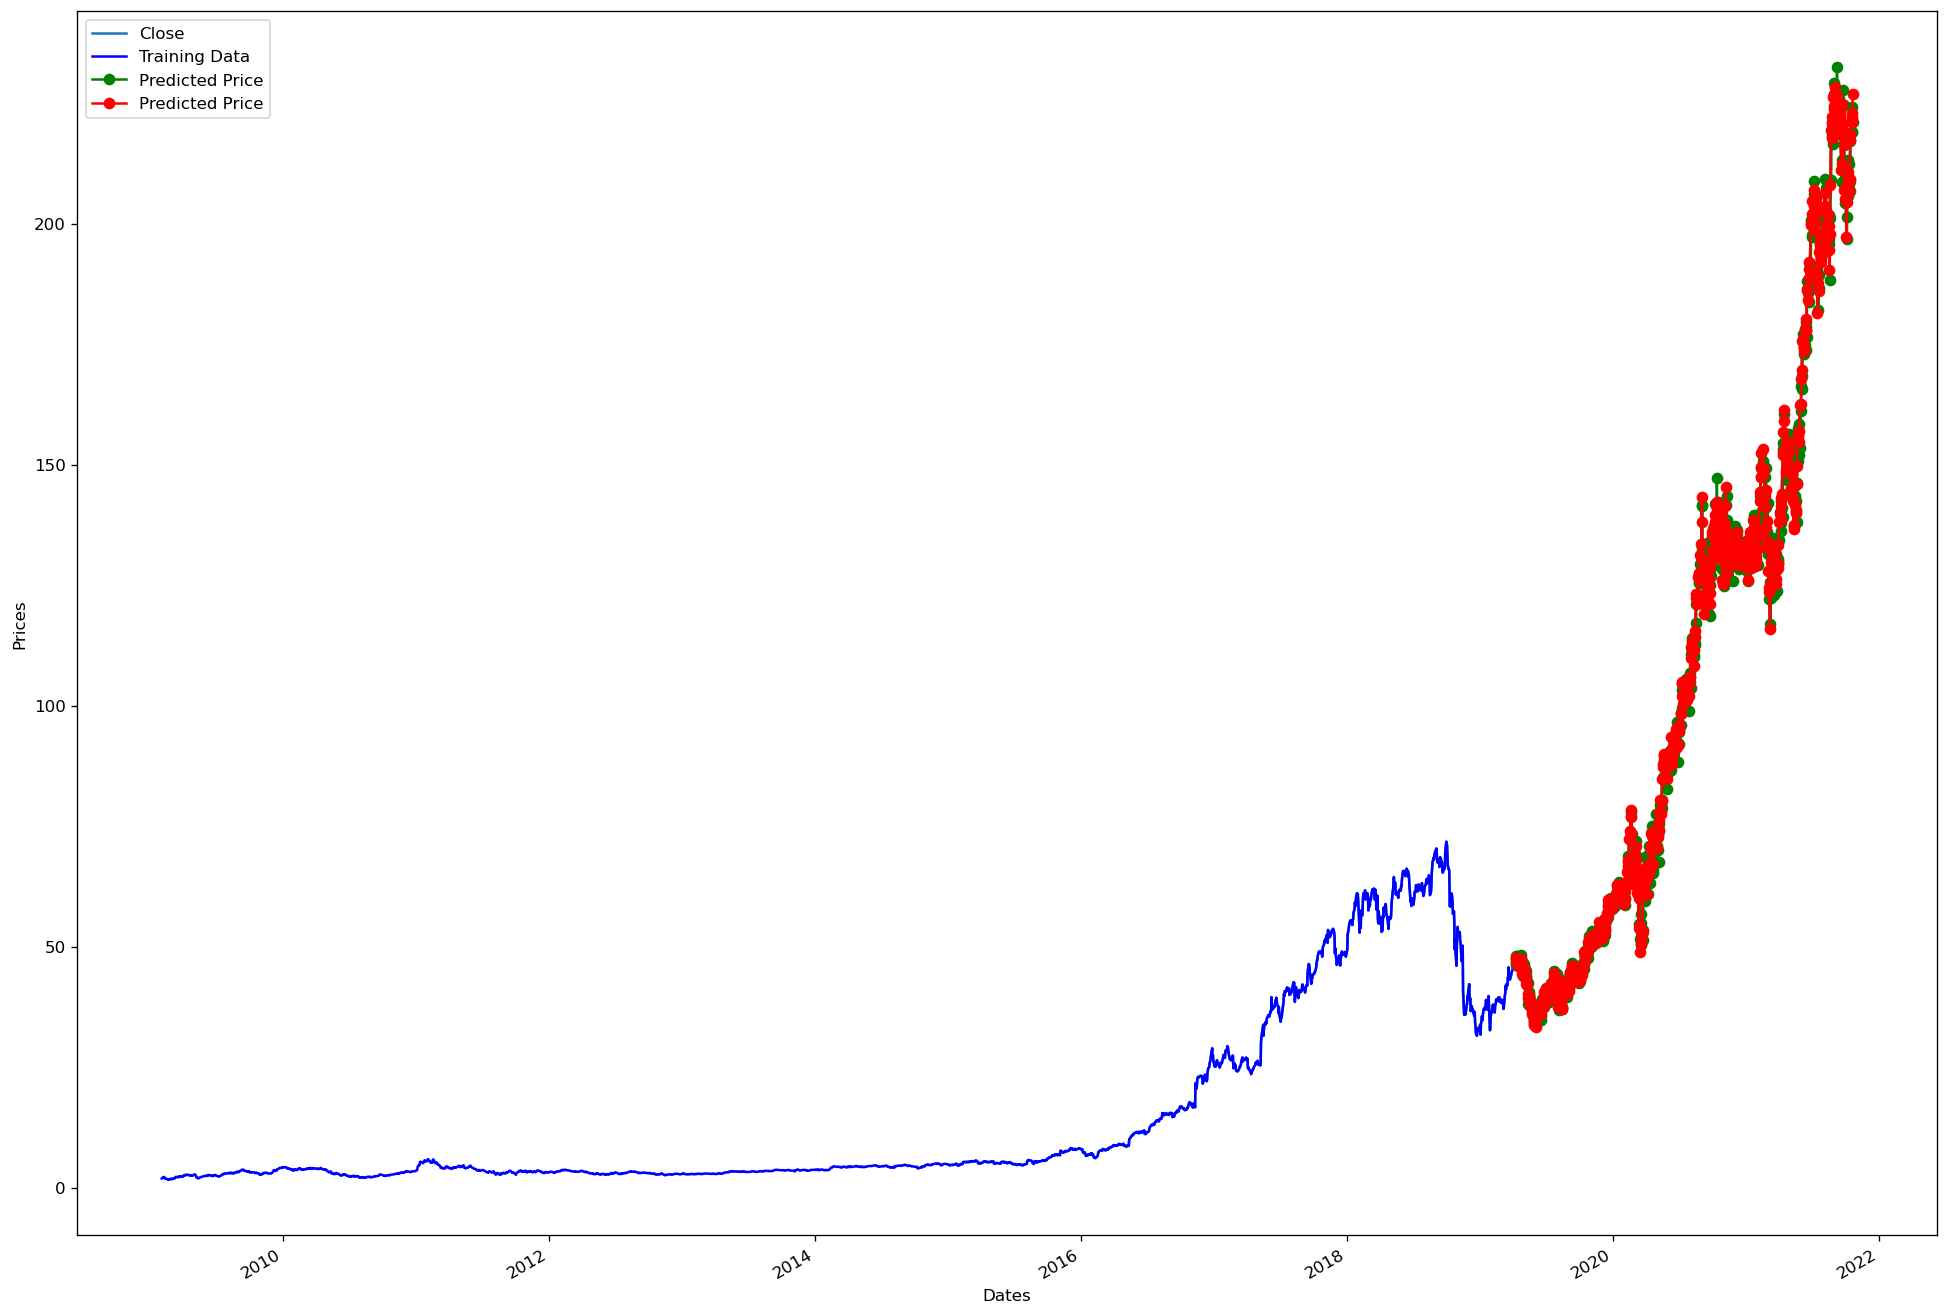

In [33]:
ax = nvda_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [35]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(12.300929986731465), 2)))

The Root Mean Squared Error of prediction is 3.51


## FBPROPHET

In [36]:
nvda_close =nvda[['Close']]

In [37]:
nvda = nvda_close.reset_index()

In [38]:
nvda

,Date,Close
0,2009-02-02,1.924725
1,2009-02-03,1.947692
2,2009-02-04,2.002816
3,2009-02-05,2.149811
4,2009-02-06,2.266948
...,...,...
3199,2021-10-15,218.619995
3200,2021-10-18,222.220001
3201,2021-10-19,222.899994
3202,2021-10-20,221.029999


In [39]:
nvda.rename(columns={'Close': 'y', 'Date': 'ds'},inplace=True)
nvda['ds'] = pd.to_datetime(nvda['ds'])
nvda['y']=nvda['y'].astype(float)

In [40]:
df_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=False)
df_prophet.fit(nvda)

In [41]:

fcast_time=365   # 1 year
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D')
df_forecast.tail(10)

,ds
3559,2022-10-12
3560,2022-10-13
3561,2022-10-14
3562,2022-10-15
3563,2022-10-16
3564,2022-10-17
3565,2022-10-18
3566,2022-10-19
3567,2022-10-20
3568,2022-10-21


In [42]:
# Forecasting - call the method predict
df_forecast = df_prophet.predict(df_forecast)

In [43]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3564,2022-10-17,268.350056,249.800035,284.246536
3565,2022-10-18,268.512907,249.531667,285.299953
3566,2022-10-19,268.636697,250.502443,285.327438
3567,2022-10-20,268.688618,248.989595,286.117138
3568,2022-10-21,268.769183,249.593360,286.088505


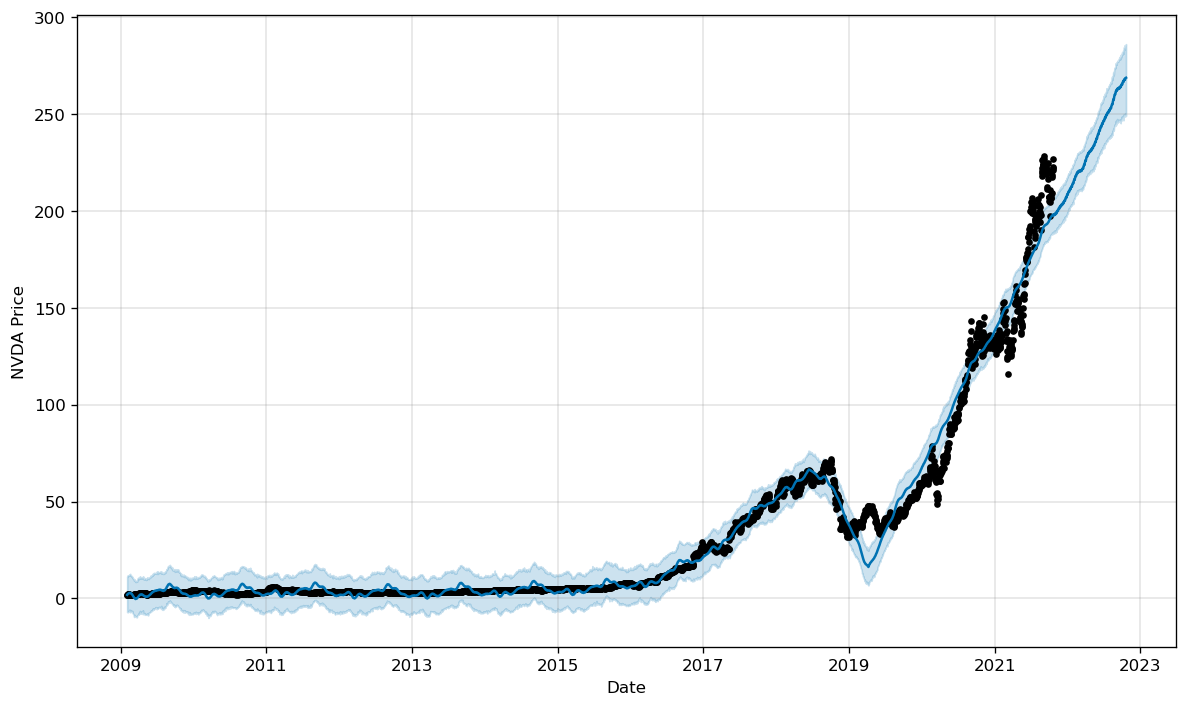

In [44]:
df_prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'NVDA Price');

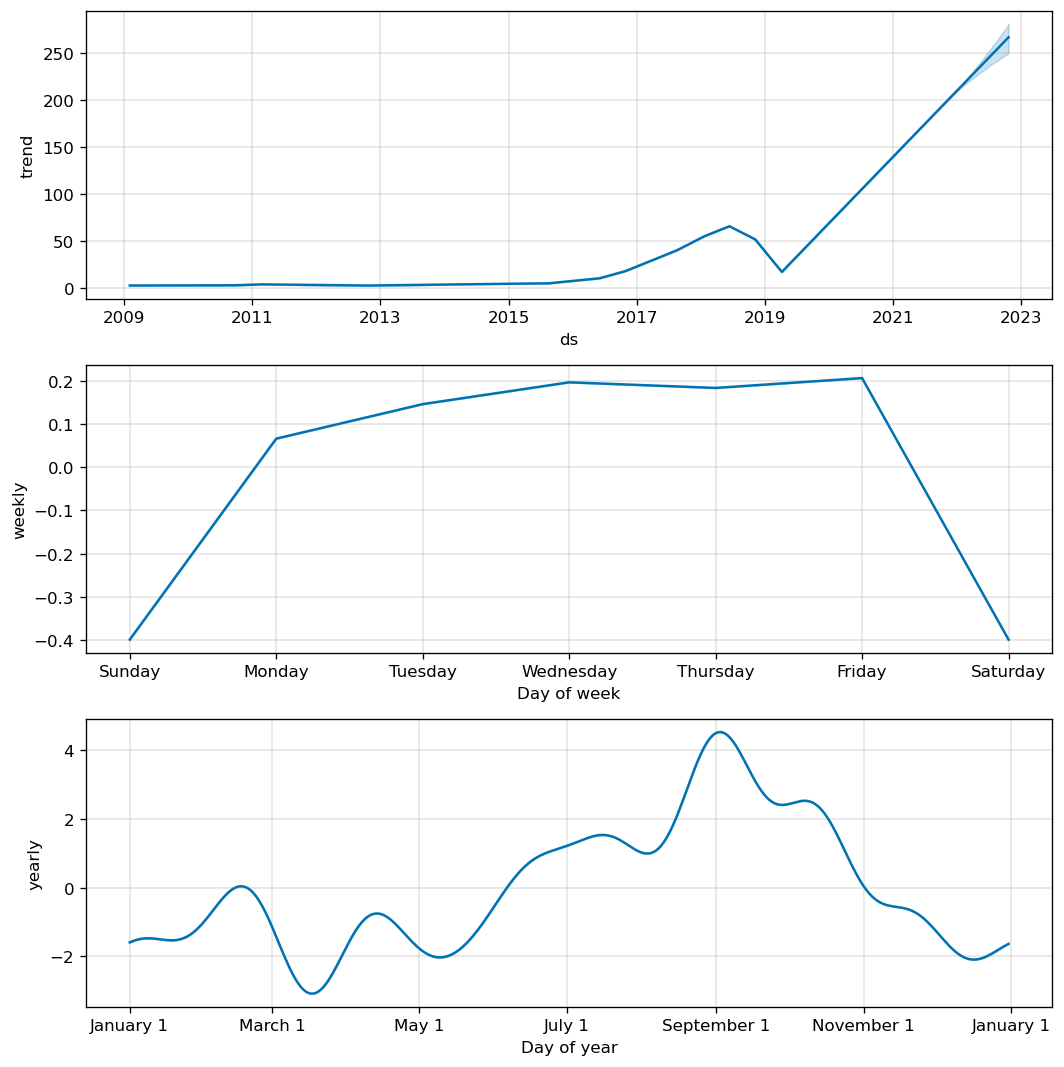

In [45]:

fig2 = df_prophet.plot_components(df_forecast)
plt.show()

In [46]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(df_prophet, horizon = '365 days')

INFO:prophet:Making 18 forecasts with cutoffs between 2012-04-23 12:00:00 and 2020-10-21 00:00:00
100%|██████████| 18/18 [03:36<00:00, 12.02s/it]


In [47]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,233.340274,15.275479,8.413483,0.187829,0.156365,0.192743,0.279709
1,37 days 00:00:00,239.425520,15.473381,8.554942,0.190773,0.157039,0.195322,0.274336
2,37 days 12:00:00,240.225951,15.499224,8.585020,0.192776,0.157656,0.197300,0.270860
3,38 days 00:00:00,242.011624,15.556723,8.643431,0.195839,0.160981,0.199946,0.263590
4,38 days 12:00:00,239.865398,15.487589,8.600506,0.196810,0.160305,0.200619,0.265171


## Result

The ARIMA model performed the best with the lowest rmse